# Pathway activity inference from scRNA-seq data with PROGENy

## Introduction

Conventional pathway analysis methods rely on the gene expression of the pathway members. However, this approach overlook the effect of post-translational modifications and only captures very specific experimental conditions. To overcome these limitations, PROGENy (Pathway RespOnsive GENes) estimates the activity of relevant signaling pathways based on consensus gene signatures obtained from perturbation experiments, in other words, the footprint of the pathway on gene expression (Schubert et al. 2018, Dugourd and Saez-Rodriguez 2019). For an introduction to Footprint-based enrichment analysis please visit this other [notebook](https://github.com/saezlab/progeny-py/blob/main/example/progeny_introduction.ipynb).

PROGENy initially contained 11 pathways and was developed for the application to human transcriptomics data. It has been recently shown that PROGENy is also applicable to mouse data (Holland, Szalai, and Saez-Rodriguez 2019) and to single cell RNAseq data (Holland et al. 2019). In addition, they expanded human and mouse PROGENy to 14 pathways.

This vignette shows an example on how to apply PROGENy in a well known single-cell dataset. To analyse the data, we followed the standard procedures of the Scanpy toolkit for single cell genomics (Wolf et al. 2018).

Here we load the packages required to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import progeny
import matplotlib.pyplot as plt

## Single-cell RNA-seq dataset
### Data description

In the following paragraphs, we provide examples describing how to run PROGENy in a scRNA-seq dataset using the Scanpy toolkit for single cell genomics (Wolf et al. 2018). For the sake of simplicity, we follow the example provided in the following Scanpy vignette:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

The dataset contains 2700 Peripheral Blood Mononuclear Cells (PBMC) that were sequenced on the Illumina NextSeq 500. This dataset is freely available in 10X Genomics:

https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

On a unix system, you can uncomment and run the following to download and unpack the data:

In [2]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',                
    cache=True)                              
adata.var_names_make_unique()

### Pre-processing, normalization and identification of highly variable features

We follow the standard pre-processing steps as described in the aforementioned Scanpy vignette before going deeper into the data analysis. These steps carry out the selection and filtration of cells based on quality control metrics, the data normalization and scaling, and the detection of highly variable features.

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)#min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/badi/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Clustering cells

One of the most relevant steps in scRNA-seq data analysis is clustering. Cells are grouped based on the similarity of their transcriptomic profiles. We first apply the Scanpy approach as described in their aforementioned tutorial. We visualize the cell clusters using UMAP:

In [5]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]

adata.rename_categories('leiden', new_cluster_names)
adata.obs["cell_type"] = adata.obs['leiden']

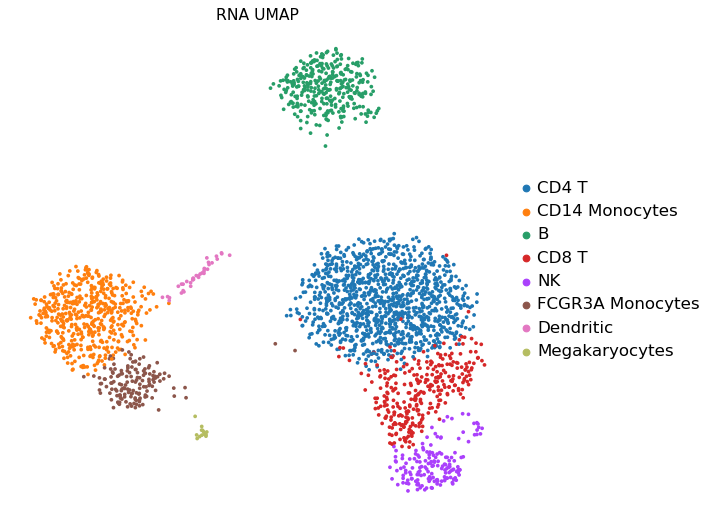

In [6]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color='leiden', title='RNA UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

## Pathway activity prediction

### Method

As previously mentioned, PROGENy can be coupled to any foot-print based enrichment analysis statistic to estimate pathway activities from expression data. Specifically, in this package we implemented the normalized mean controlled by permutations. Given a pathway with $n$ number of target genes $g = (g_1, ... g_n)$ and weights $w = (w_1, ... w_n)$, its estimated activity is defined as:

$ E = \frac{\sum_{i=1}^{n}{g_i w_i}}{n} $

Activities are normalized by $n$ to control for large regulons. Moreover, to control for false estimations we calculate the probability of observing the estimated activity by chance, by performing $m$ permutations:

$pval = \frac{\sum_{i=1}^{m}{\left\lvert R_i \right\rvert > \left\lvert E \right\rvert}}{m}$

Where $R_i$ is the predicted activity using $n$ random target genes. Finally, the final pathway activity $A$ is calculated by weighting $E$ by its $pval$:

$A = E * -\log_{10}(pval)$

Therefore, cells will show high absolute values of pathway activity if their estimate is robust, otherwise their predicted activity will be close to 0. 

### Prediction

To predict pathway activities, first we need to load PROGENy model (only available for Human and Mouse):

In [7]:
model = progeny.load_model(
    organism='Human', # If working with mouse, set to Mouse
    top=1000          # For sc we recommend ~1k target genes since there are dropouts
)

We recommend to use the log-normalized values of the whole available universe of genes for pathway activity estimation. To run the method use:

In [8]:
progeny.run(adata,        # Data to use
            model,        # PROGENy network
            center=True,  # Center gene expression by mean per cell
            num_perm=100, # Simulate m random activities
            norm=True,    # Normalize by number of edges to correct for large regulons
            scale=True,   # Scale values per feature so that values can be compared across cells
            use_raw=True, # Use raw adata, where we have the lognorm gene expression
            min_size=5    # Pathways with less than 5 targets will be ignored
           )

 10%|█         | 10/100 [00:00<00:00, 94.62it/s]

6512 genes found


100%|██████████| 100/100 [00:01<00:00, 89.63it/s]


The resulting activities are stored in the `.obsm` attribute of an `AnnData` object. To access them use the key `progeny`:

In [9]:
adata.obsm['progeny']

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACATACAACCAC-1,-0.796388,1.339694,0.334913,-0.320536,0.033618,0.527462,0.750845,0.445771,-0.045753,0.418104,0.332607,-0.975807,-0.541656,-0.911945
AAACATTGAGCTAC-1,0.100842,0.176181,2.270546,-0.206837,0.072087,0.401894,-0.597043,-0.280475,-0.435279,-0.682817,1.659904,0.910008,-0.642496,0.063186
AAACATTGATCAGC-1,-0.321594,1.922555,-0.147694,-0.320726,-0.473326,0.021819,0.992114,-0.009946,0.776342,1.478161,0.339507,-0.417761,-0.776694,0.011516
AAACCGTGCTTCCG-1,1.782503,-0.258753,-0.233525,0.181782,0.173739,0.201113,-0.460538,0.190268,0.292732,-0.217362,0.817677,-0.382165,-0.288246,1.605327
AAACCGTGTATGCG-1,-0.091439,2.339449,-0.068672,-0.999420,-0.018762,0.311689,0.816455,-0.044244,-0.169582,-0.213149,-0.998789,1.414408,-0.772119,0.058632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1.592535,-0.586925,-0.126655,-0.750136,4.280532,0.203407,2.142200,-0.049599,-0.025593,2.145427,0.226212,0.697791,-0.661513,1.109417
TTTCTACTGAGGCA-1,-0.036326,0.762167,3.072470,1.950827,0.090942,0.234617,-0.512609,-0.080023,-0.359610,-0.719519,-0.354638,-0.168357,1.671316,-2.839480
TTTCTACTTCCTCG-1,-0.982101,2.622072,-0.132376,-0.606068,0.022048,1.194381,-0.313858,1.353166,0.501695,-0.698724,-0.506910,-0.127913,-0.531319,0.720686
TTTGCATGAGAGGC-1,-0.019230,-0.909708,-0.049513,-0.923631,0.094827,0.257410,-0.228405,-0.159034,0.418140,-0.705105,-0.683799,-1.200574,0.403722,-0.035925


Or use `extract` to return an AnnData object to be able to use scanpy's amazing plotting functions:

In [10]:
progeny.extract(adata)

AnnData object with n_obs × n_vars = 2638 × 14
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    obsm: 'X_pca', 'X_umap', 'progeny'

### Pathway activity per cell population

Let's plot the obtained activities on the previously annotated clusters:

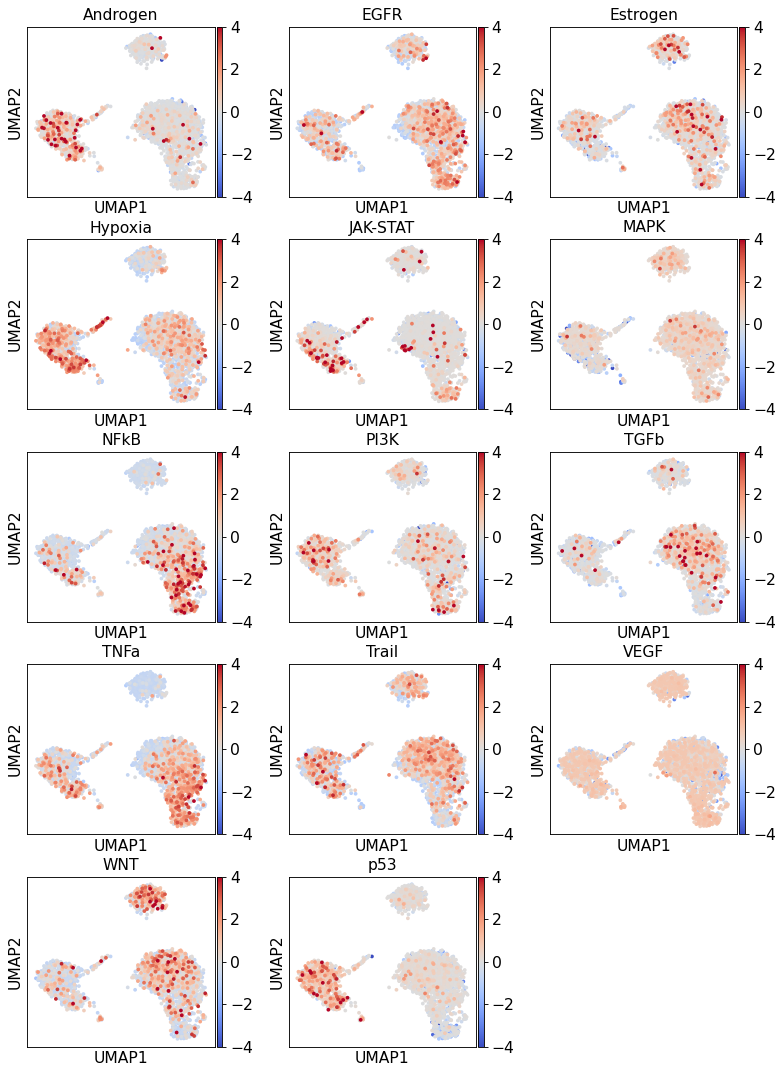

In [11]:
pw_adata = progeny.extract(adata)
sc.set_figure_params(figsize=(3,3))
sc.pl.umap(pw_adata, color=pw_adata.var.index, vmin=-4, vmax=4, cmap='coolwarm', ncols=3)

Here is a summary per cell type:

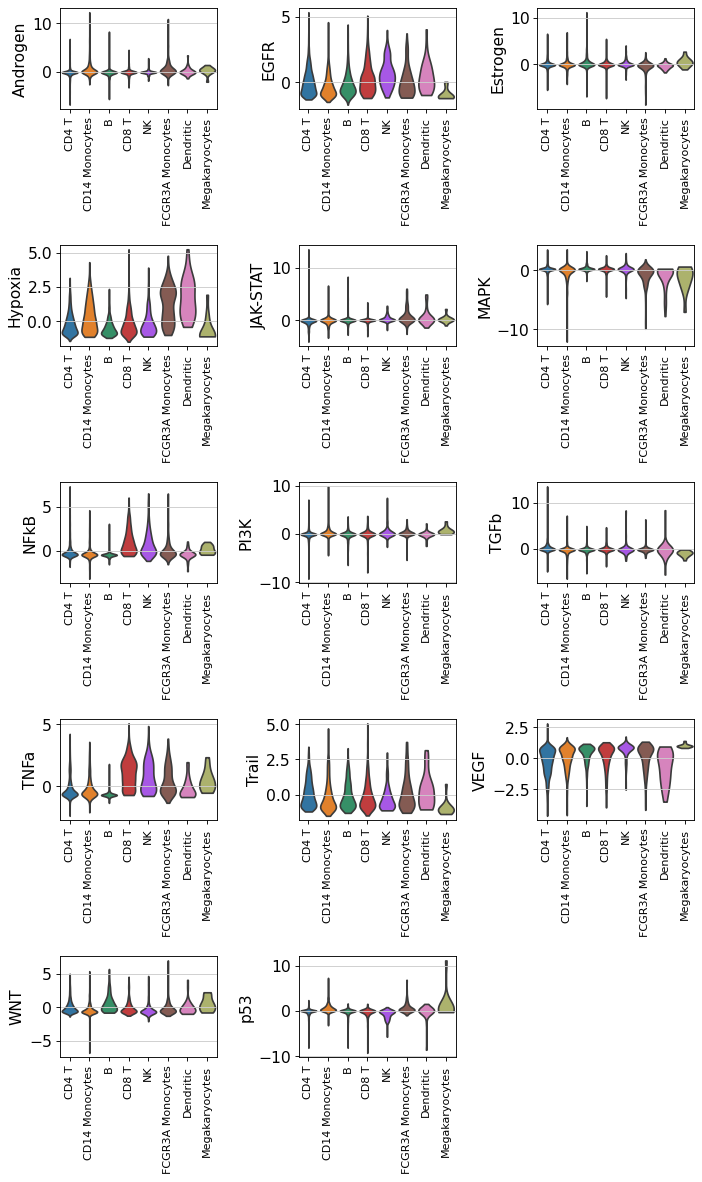

In [12]:
fig, axes = plt.subplots(5,3, figsize=(3*3,5*3), tight_layout=True)
axes = axes.flatten()
for pw,ax in zip(pw_adata.var.index, axes):
    sc.pl.violin(pw_adata, keys=pw, groupby='cell_type', stripplot=False, ax=ax, show=False)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
axes[-1].set_visible(False)
fig.tight_layout()
plt.show()

## Comparison of pathway activities between groups

Once pathway activities are predicted, we can perform comparison tests to check if there are differences between groups. To do, we have implemented a wrapper for the Wilcoxon rank-sum test. Let's find what pathways are activaten in CD8 T cells:

In [13]:
df = progeny.rank_pws_groups(adata, groupby='cell_type', group='CD8 T')
df

,group,reference,statistic,meanchange,pval,pval_adj
name,,,,,,
TNFa,CD8 T,all,17.791763,1.176244,8.186296e-71,5.730407e-70
NFkB,CD8 T,all,18.087200,1.130269,4.019973e-73,5.627962e-72
EGFR,CD8 T,all,5.002474,0.315050,5.659920e-07,1.980972e-06
MAPK,CD8 T,all,3.322969,0.174170,8.906486e-04,2.493816e-03
VEGF,CD8 T,all,3.153857,0.114513,1.611281e-03,3.222562e-03
TGFb,CD8 T,all,0.128520,0.035215,8.977372e-01,8.977372e-01
JAK-STAT,CD8 T,all,3.261103,0.007911,1.109795e-03,2.589522e-03
Estrogen,CD8 T,all,0.989726,0.003555,3.223079e-01,4.102101e-01
PI3K,CD8 T,all,0.448863,-0.026560,6.535303e-01,7.038019e-01


Let's plot the mean activity per cell type:

/home/badi/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


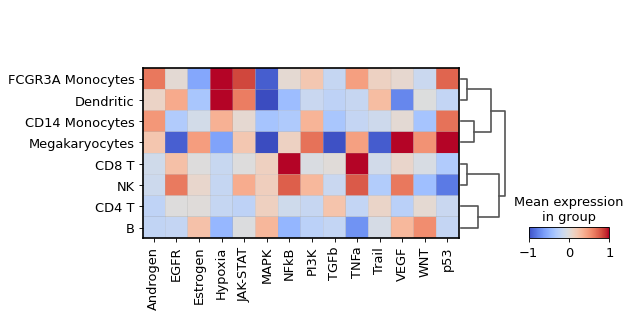

In [14]:
pws = pw_adata.var.index
sc.pl.matrixplot(pw_adata, pws, 'cell_type', dendrogram=True, cmap='coolwarm', vmin=-1, vmax=1)

## Clustering cells with TF activity

Clustering cells based on their pathway activity profiles can also be very interesting:

In [15]:
proj_adata = progeny.extract(adata)
proj_adata.obsm['X_pca'] = proj_adata.obsm['progeny']
sc.pp.neighbors(proj_adata, n_neighbors=10, n_pcs=proj_adata.obsm['progeny'].shape[1])
sc.tl.umap(proj_adata)
sc.tl.leiden(proj_adata)

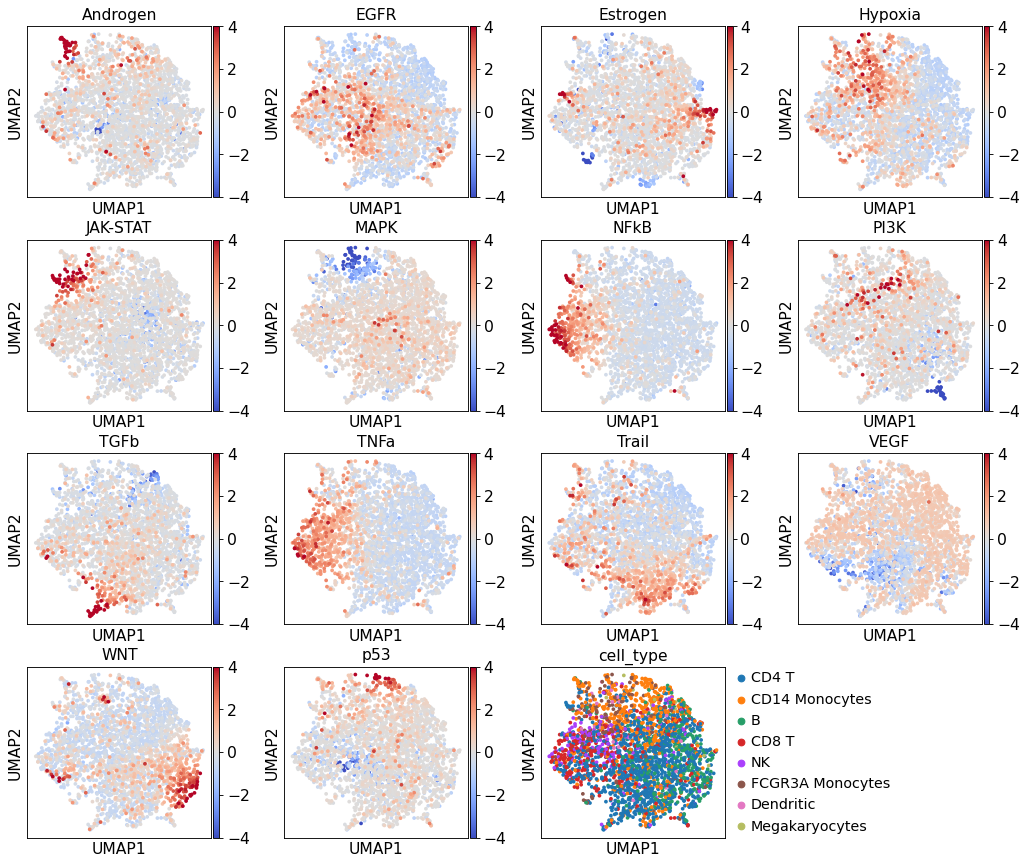

In [16]:
sc.pl.umap(proj_adata, color=list(proj_adata.var.index) + ['cell_type'], cmap='coolwarm', vmin=-4, vmax=4)

## Session info

In [17]:
sc.logging.print_versions(file=None)

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.3
llvmlite            0.36.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.53.0
numexpr             2.7.3
numpy               1.20.1
packaging           20.9
pandas              1.2.3
parso               0.8.0
patsy               0.5.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
progeny             NA
prompt_toolkit      3.0.8
ptypro

# References

- Dugourd, Aurelien, and Julio Saez-Rodriguez. 2019. “Footprint-Based Functional Analysis of Multiomic Data.” Current Opinion in Systems Biology 15 (June): 82–90. https://doi.org/10.1016/j.coisb.2019.04.002.


- Schubert M, Klinger B, Klünemann M, Sieber A, Uhlitz F, Sauer S, Garnett MJ, Blüthgen N, Saez-Rodriguez J. “Perturbation-response genes reveal signaling footprints in cancer gene expression.” Nature Communications: https://doi.org/10.1038/s41467-017-02391-6


- Holland, Christian H., Jovan Tanevski, Javier Perales-Patón, Jan Gleixner, Manu P. Kumar, Elisabetta Mereu, Brian A. Joughin, et al. 2020. “Robustness and Applicability of Transcription Factor and Pathway Analysis Tools on Single-Cell RNA-Seq Data.” Genome Biology 21 (1). https://doi.org/10.1186/s13059-020-1949-z. 


- Wolf, Alexander, Angerer, Philipp and Theis, Fabian. 2018."SCANPY: large-scale single-cell gene expression data analysis". Genome Biology 19 (15). https://doi.org/10.1186/s13059-017-1382-0